# NLOS with HHL

## 1. NLOS Test case generation

### Layout of testcase generation

1. Set SV at origin $(0, 0, 0)$
1. Based on $r_{min}$ and $r_{max}$, generate random HV position. `numpy.random.rand()` is used. 
1. Randomly create total of `num_points` points, each point's distance being farther away than $d_{min}$ but closer to each points than $d_{max}$.
1. Compute necessary quantities($\phi, \, \psi,\, \text{etc...}$)

In [1]:
import numpy as np

In [2]:
def dist(a: np.ndarray, b: np.ndarray):
    if a.shape != b.shape:
        raise ValueError("inconsistent point shape")
    return np.sqrt(np.sum((a - b) ** 2))

In [3]:
class NLOStestcase:
    """
    One randomized test case (NLOS geometry). Does not enforce NLOS by itself,
    just generates geometry.
    """
    def __init__(self: "NLOStestcase", sample_point_cnt: int, HV_r_min: float, HV_r_max: float, 
                 sample_r_min: float, sample_r_max: float, HV_orientation: float | None = None,
                 HV: tuple[float, float, float] | None = None, sample_points: tuple | list | None = None):
        
        if HV_r_min < 0 or HV_r_max < 0 or HV_r_min > HV_r_max:
            raise ValueError("HV radius restriction inappropriate")
        if HV_orientation is not None and (HV_orientation < 0 or HV_orientation > 2 * np.pi):
            raise ValueError("Inappropriate HV orientation")
        if sample_r_min < 0 or sample_r_max < 0 or sample_r_max < sample_r_min:
            raise ValueError("sample point distance restriction inappropriate")
        if sample_point_cnt <= 0:
            raise ValueError(f"Too small sample_point_cnt: {sample_point_cnt}")
        if (sample_points is not None and len(sample_points) != sample_point_cnt):
            raise ValueError("Sample point count/actual list mismatch")

        self.SV = np.zeros(3)

        self.sample_r_min = sample_r_min
        self.sample_r_max = sample_r_max
        
        if HV is None:
            self.HV = self._sample_point_in_shell(HV_r_min, HV_r_max)
            print(f"HV position set randomly: {self.HV}")
        else:
            self.HV = HV
            print(f"HV position set to given parameter: {self.HV}")
        
        if HV_orientation is None:
            self.HV_orientation = np.random.random() * 2 * np.pi
        else:
            self.HV_orientation = HV_orientation

        # if dist between HV and SV is greater than sample_r_max * 2, throw
        print("SV: {0}, HV: {1}".format(self.HV, self.SV))
        if dist(self.HV, self.SV) > sample_r_max * 2.5:
            raise ValueError("sample_r_max is too small")
        
        # set the reflection sample points
        self.sample_point_cnt = sample_point_cnt
        if sample_points is None:
            points = set()
            while len(points) < self.sample_point_cnt:
                point = self._sample_point_in_shell(sample_r_min, sample_r_max)
                if sample_r_min < dist(point, self.HV) < sample_r_max:
                    points.add(tuple(point))
            self.sample_points = [np.array(x) for x in points]
        else:
            self.sample_points = sample_points

        # convert each point to NLOS-used spherical coordinates
        self.sample_spherical_points = []
        for x in self.sample_points:
            self.sample_spherical_points.append(np.array(self._to_NLOS_coordinates(x)))
        
        # add rho * c(time difference) to last array member
        self._add_rho()

        # sort by dist
        self.sample_spherical_points.sort(key=lambda x: x[0])
        print([x[6] for x in self.sample_spherical_points])

        # initialize
        self.A = np.zeros((3 * (self.sample_point_cnt - 1), (self.sample_point_cnt + 1)))
        self.b = np.zeros((3 * (self.sample_point_cnt - 1),))

        # todo: change this
        self.omega = self.HV_orientation

    def _random_direction_3d(self) -> np.ndarray:
        """
        Sample a random direction uniformly on the unit sphere S^2.
        """
        v = np.random.normal(size=3)
        norm = np.linalg.norm(v)
        if norm < 1e-12:
            # extremely unlikely; resample if it happens
            return self._random_direction_3d()
        return v / norm
    
    def _sample_point_in_shell(self, r_min: float, r_max: float) -> np.ndarray:
        """
        Sample a random 3D point whose distance from the origin is in [r_min, r_max].
        Direction is uniform; radius is uniform in [r_min, r_max] (not volume-uniform).
        """
        direction = self._random_direction_3d()
        r = r_min + (r_max - r_min) * np.random.rand()
        return r * direction
    
    def _cartesian_to_spherical(self, point: np.ndarray):
        r = dist(np.array([0, 0, 0]), point)
        rho = np.sqrt(np.sum(point[:2] ** 2))
        phi = np.arctan2(point[1], point[0])
        psi = np.arctan2(rho, point[2])
        return r, phi, psi
    
    def _to_NLOS_coordinates(self, point: np.ndarray):
        """returns d, v, theta, vartheta, phi, psi"""
        v, theta, var_theta = self._cartesian_to_spherical(point)
        v_p, phi_p, psi = self._cartesian_to_spherical(point - self.HV)
        
        phi = phi_p - self.HV_orientation
        if phi < 0: 
            phi += 2 * np.pi

        return (v + v_p, v, theta, var_theta, phi, psi, 0)
    
    def _add_rho(self):
        d_1 = min([x[0] for x in self.sample_spherical_points])
        for x in self.sample_spherical_points:
            x[-1] = x[0] - d_1

    def set_A(self, omega):
        # self sphereical points:
        # d, v, theta, var_theta, phi, psi, rho * c
        # 0, 1, 2,     3,         4,   5,   6
        
        # first point
        p1 = self.sample_spherical_points[0]

        # x direction matrix: assume point list is sorted
        for i, x in enumerate(self.sample_spherical_points[1:]):
            # - ( sin(var_theta) * cos(theta) + sin(psi) cos(phi+w) )
            self.A[i, 0] = -(np.sin(p1[3]) * np.cos(p1[2]) + np.sin(p1[5]) * np.cos(p1[4] + omega))

            # sin(var_theta) * cos(theta) + sin(psi) cos(phi+w)
            self.A[i, i + 1] = (np.sin(x[3]) * np.cos(x[2]) + np.sin(x[5]) * np.cos(x[4] + omega))
            
            # sin(psi_1) cos(phi_1 + omega) - sin(psi_p) cos(phi_p + omega)
            self.A[i, self.sample_point_cnt] = np.sin(p1[5]) * np.cos(p1[4] + omega) - np.sin(x[5]) * np.cos(x[4] + omega)
        
        # y direction matrix
        for i, x in enumerate(self.sample_spherical_points[1:]):
            self.A[(self.sample_point_cnt - 1) + i, 0] = -(np.sin(p1[3]) * np.sin(p1[2]) + np.sin(p1[5]) * np.sin(p1[4] + omega))

            self.A[(self.sample_point_cnt - 1) + i, i + 1] = (np.sin(x[3]) * np.sin(x[2]) + np.sin(x[5]) * np.sin(x[4] + omega))

            self.A[(self.sample_point_cnt - 1) + i, self.sample_point_cnt] = np.sin(p1[5]) * np.sin(p1[4] + omega) - np.sin(x[5]) * np.sin(x[4] + omega)
        
        # z direction matrix
        for i, x in enumerate(self.sample_spherical_points[1:]):
            self.A[(self.sample_point_cnt - 1) * 2 + i, 0] = -(np.cos(p1[3]) + np.cos(p1[5]))

            self.A[(self.sample_point_cnt - 1) * 2 + i, i + 1] = (np.cos(x[3]) + np.cos(x[5]))
            
            self.A[(self.sample_point_cnt - 1) * 2 + i, self.sample_point_cnt] = np.cos(p1[5]) - np.cos(x[5])
        
        print("A successfully set")

    def set_b(self, omega):
        # self sphereical points:
        # d, v, theta, var_theta, phi, psi, rho * c
        # 0, 1, 2,     3,         4,   5,   6

        # x direction
        for i, x in enumerate(self.sample_spherical_points[1:]):
            self.b[i] = x[6] * np.sin(x[5]) * np.cos(x[4] + omega)
        
        # y direction
        for i, x in enumerate(self.sample_spherical_points[1:]):
            self.b[(self.sample_point_cnt - 1) + i] = x[6] * np.sin(x[5]) * np.sin(x[4] + omega)
        
        # z direction
        for i, x in enumerate(self.sample_spherical_points[1:]):
            self.b[(self.sample_point_cnt - 1) * 2 + i] = x[6] * np.cos(x[5])

        print("b successfully mounted")

## 2. NLOS Preparation

### Method for obtaining $\omega$

$\omega$ is required to determine $\textbf{A}(\omega)$ and $\textbf{B}(\omega)$.

$\omega$ is determined by the equation $\text{null}(\textbf{A}(\omega)^\text{T})^\text{T} \textbf{B}(\omega)=0$.

Current implementation: Linear search

In [4]:
testcase = NLOStestcase(4, 10, 15, 8, 12)
testcase.set_A(testcase.omega)
testcase.set_b(testcase.omega)
print(testcase.HV)
print("-----------", testcase.A, "-------------", testcase.b, "------------", sep='\n')
classic_sol = np.linalg.lstsq(testcase.A, testcase.b)[0]
print(classic_sol)
print([x[1] for x in testcase.sample_spherical_points])

HV position set randomly: [  8.42982099   7.06423896 -10.08564151]
SV: [  8.42982099   7.06423896 -10.08564151], HV: [0. 0. 0.]
[np.float64(0.0), np.float64(0.19822671848434936), np.float64(0.2757913336210649), np.float64(1.6506602652804219)]
A successfully set
b successfully mounted
[  8.42982099   7.06423896 -10.08564151]
-----------
[[ 0.92983257  0.99229614  0.          0.         -0.96156246]
 [ 0.92983257  0.         -0.92095719  0.         -0.0351136 ]
 [ 0.92983257  0.          0.         -0.97412655 -0.12372762]
 [-0.12827816 -0.43252482  0.          0.          0.25896517]
 [-0.12827816  0.          0.87848024  0.         -0.40068464]
 [-0.12827816  0.          0.         -0.48305916  0.25563484]
 [ 0.8682811   0.71580704  0.          0.         -0.79531742]
 [ 0.8682811   0.         -0.2583219   0.         -0.33961433]
 [ 0.8682811   0.          0.         -0.9055634  -0.04415849]]
-------------
[ 1.29724357e-03 -2.53701721e-01 -1.37217836e+00 -1.09638536e-01
  2.93864348e-0

## 3. HHL Implementation

### Defs

In [5]:
import math
import numpy as np
import qiskit
from scipy.linalg import expm
from qiskit.circuit.library import StatePreparation, ExactReciprocalGate, phase_estimation
from qiskit.quantum_info import Statevector, Operator
from qiskit_aer import AerSimulator
from qiskit.compiler import transpile
from qiskit.result import Result
from qiskit.circuit import IfElseOp, QuantumCircuit, QuantumRegister, ClassicalRegister, Gate
from qiskit.circuit.library import Initialize , UnitaryGate , QFTGate, ExactReciprocalGate, UCRYGate

from qiskit.quantum_info.operators.predicates import is_unitary_matrix

In [6]:
def progress_callback(**kwargs):
    pass_name = kwargs['pass_'].name()
    count = kwargs['count']
    # The DAG circuit is an internal representation that can be inspected
    dag = kwargs['dag'] 
    print(f"Pass {count}: {pass_name}, Operations: {dag.count_ops()}")


def hhl_fidelity(x_classic, probs_hhl):
    # Classical solution
    x = x_classic / np.linalg.norm(x_classic)

    # Rebuild complex vector from probabilities (up to global phase)
    # HHL gives only magnitudes; pick sign so inner product is maximized
    # Just treat as positive real for fidelity purposes

    probs_classical = np.abs(x) ** 2
    probs_classical = probs_classical / probs_classical.sum()

    # Normalize HHL probs just in case
    probs_hhl = probs_hhl / probs_hhl.sum()

    # Probability "fidelity" (Bhattacharyya coefficient)
    fidelity = float(np.sum(np.sqrt(probs_classical * probs_hhl)))
    # Numerical safety for arccos
    fidelity_clamped = max(min(fidelity, 1.0), -1.0)
    angle = float(np.rad2deg(np.arccos(fidelity_clamped)))

    return fidelity, angle

In [ ]:
class CustomExactReciprocalGate(Gate):

    def __init__(
        self, num_state_qubits: int, scaling: float, neg_vals: bool = False, kappa: float | None = None, cutoff_ratio: float = 2.0, label: str = "1/x"
    ) -> None:
        super().__init__("CustomExactReciprocal", num_state_qubits + 1, [], label=label)

        self.scaling = scaling
        self.neg_vals = neg_vals
        self.kappa = kappa
        self.cutoff_ratio = cutoff_ratio
    
    def _f_lambda(self, lam: float) -> float:
        def f_original(lam):
            if math.isclose(self.scaling / lam, 1.0, abs_tol=1e-05):
                return 1.0
            elif self.scaling / lam < 1.0:
                return self.scaling / lam
            return 0.0

        if self.kappa is None:
            return f_original(lam)
        
        # original HHL paper for f(lambda)
        # if 1/kap_p < lambda < 1/kap: transition area
        # if lambda < 1/kap_p: too small lambda, don't rotate
        # if lamdba > 1/kap: good lambda, behave like original HHL
        kap = self.kappa
        kap_p = kap * self.cutoff_ratio

        # good area
        if lam >= 1 / kap:
            return f_original(lam)

        # bad area: not rotate at all
        if lam < 1 / kap_p:
            return 0.0
        
        # transition area
        t = (lam - 1 / kap_p) / (1 / kap - 1 / kap_p)
        return f_original(1 / kap) * math.sin(0.5 * math.pi * t)



    def _define(self):
        num_state_qubits = self.num_qubits - 1
        qr_state = QuantumRegister(num_state_qubits, "state")
        qr_flag = QuantumRegister(1, "flag")
        circuit = QuantumCircuit(qr_state, qr_flag)

        angles = [0.0]
        nl = 2 ** (num_state_qubits - 1) if self.neg_vals else 2**num_state_qubits

        # Angles to rotate by scaling / x, where x = i / nl
        for i in range(1, nl):
            lam = i / nl
            f = self._f_lambda(lam)
            if math.isclose(f, 1.0, abs_tol = 1e-5):
                angles.append(np.pi)
            elif f <= 0.0:
                angles.append(0.0)
            else:
                angles.append(2 * math.asin(f))

        circuit.append(UCRYGate(angles), [qr_flag[0]] + qr_state[: len(qr_state) - self.neg_vals])

        if self.neg_vals:
            circuit.append(
                UCRYGate([-theta for theta in angles]).control(),
                [qr_state[-1]] + [qr_flag[0]] + qr_state[:-1],
            )
            angles_neg = [0.0]
            for i in range(1, nl):
                lam_neg = -(1.0 - i / nl)
                lam = abs(lam_neg)
                f = self._f_lambda(lam)

                if math.isclose(f, 1.0, abs_tol = 1e-5):
                    angles_neg.append(-np.pi)
                elif f <= 0.0:
                    angles_neg.append(0.0)
                else:
                    angles_neg.append(-2 * math.asin(f))

            circuit.append(
                UCRYGate(angles_neg).control(), [qr_state[-1]] + [qr_flag[0]] + qr_state[:-1]
            )

        self.definition = circuit

In [1]:
class HHL:
    """class that implements HHL algorithm"""

    def __init__(self, A: np.typing.NDArray, b: np.typing.NDArray, state_dim: int = -1, tol=1e-05, lambda_min_eff=1e-01, force_cutoff=None):
        """A: operator matrix, b: matrix, n: number of qubits
        force_cutoff: 
            - True - Always use cutoff based on lambda_min_eff
            - None - use cutoff if eigval is  on lambda_min_eff
            - False - do not use cutoff at all times.
        """
        assert (len(A.shape) == 2 and len(b.shape) == 1), "Inconsistent dimension of A or b"
        assert (A.shape[0] == b.shape[0]), "shape of A does not match b"
        
        self.A = A.copy()
        self.b = b.copy()
        self.lambda_min_eff = lambda_min_eff

        if (self.A.shape[0] != self.A.shape[1] or not np.allclose(self.A, self.A.conj().T, atol=tol)):
            if (self.A.shape[0] != self.A.shape[1]):
                print("A is not a square matrix")
            else:
                print("A is not Hermitian")
            self.A = np.block([[np.zeros((self.A.shape[0], self.A.shape[0])), self.A],
                               [self.A.conj().T, np.zeros((self.A.shape[1], self.A.shape[1]))]])
            print("A is evaluated as [[0, A], [AT, 0]]")
            print("-----------------------------------")
            self.b = np.block([b, np.zeros(A.shape[1])])
        
        # pad A to be 2^n
        self.n_b = 0
        while (self.A.shape[0] > (1 << self.n_b)):
            self.n_b += 1
        
        if (self.A.shape[0] != (1 << self.n_b)):
            print("A is not power of 2, pad to make A {0} * {0}".format((1 << self.n_b)))
            print("-----------------------------------")
            pad = (1 << self.n_b) - self.A.shape[0]

            self.A = np.pad(self.A, ((0, pad), (0, pad)), "constant", constant_values=0)
            self.b = np.pad(self.b, (0, (1 << self.n_b) - self.b.shape[0]), "constant", constant_values=0)

        self.tol = tol
        self.dim = (1 << self.n_b)

        self.b_norm = 1

        if (not math.isclose(np.linalg.norm(self.b), 1, abs_tol=tol)):
            self.b_norm = np.linalg.norm(self.b)
            self.b = self.b.copy() / np.linalg.norm(self.b)
            print(f"b is not normalized, normalized to b = {self.b} during init")
            print("-----------------------------------")
        
        eigvals = np.linalg.eigvalsh(self.A)

        if force_cutoff or (force_cutoff is None and np.abs(eigvals).min() < lambda_min_eff):
            if not any(np.abs(eigvals) > lambda_min_eff):
                raise ValueError("lambda_min_eff is too big, all eigvals are smaller")
            
            lambda_min = np.abs(eigvals)[np.abs(eigvals) > lambda_min_eff].min()
            self.cutoff = True
            print(f"chosen mode: {force_cutoff}\nCutoff enabled: lambda_min_eff - {lambda_min_eff}, min(eigvals) - {np.abs(eigvals).min()}")

        else:
            lambda_min = np.abs(eigvals).min()
            self.cutoff = False
            print(f"chosen mode: {force_cutoff}\nCutoff disabled")
        print("-----------------------------------")

        # C for making C/λ < 1
        self.C = lambda_min * 0.9

        self.kappa = np.abs(eigvals).max() / lambda_min # characteristic number of matrix A
        # define t slightly smaller -> then if eigval is positive, < 0.45 and negative, > 0.55
        # if just pi / |lambda_max| -> 0.5 eigval errors
        self.t = np.pi / np.abs(eigvals).max() / 1.5 # calculate t

        self.phase_min_eff = lambda_min * self.t / (2 * np.pi)

        if (state_dim > 0):
            self.state_dim = state_dim
        else:
            if (self.kappa < 100):
                self.state_dim = int(np.log2(self.kappa)) + 4
            else:
                self.state_dim = 10

        self.U = expm(1j * self.t * self.A) # U = e^(iAt), then convert to unitarygate
    
    def _create_register(self):
        """call this to initially create registers, only once"""
        b_reg = QuantumRegister(self.n_b, 'sys')
        c_reg = QuantumRegister(self.state_dim, 'phase')
        aux_reg = QuantumRegister(1, 'aux')
        sign_reg = QuantumRegister(1, 'sign')
        classic_aux_reg = ClassicalRegister(1, 'classic_aux')
        result_reg = ClassicalRegister(self.n_b, 'classic_sys')
        return b_reg, c_reg, aux_reg, sign_reg, classic_aux_reg, result_reg


    def _prepare_state(self, circ: QuantumCircuit, b_reg: QuantumRegister):
        """add gate to mount b on registers"""
        # assert math.isclose(np.linalg.norm(self.b), 1, abs_tol=self.tol) # check if b is normalized
        temp_circ = QuantumCircuit(QuantumRegister(self.n_b, 'temp'))
        init_gate = StatePreparation(Statevector(self.b))
        temp_circ.append(init_gate, temp_circ.qubits)
        temp_gate = temp_circ.to_gate()
        temp_gate.label = "|b⟩ state preparation"
        circ.append(temp_gate, b_reg) # add gate for initalizing b
        circ.barrier() # separation from rest of the process

    def _assign_neg_sign(self, circ, c_reg, sign_reg):
        phase_le = list(reversed(c_reg)) # since qpe gives us big-endian, should reverse/little-endian expected in ExactReciprocalGate
        # if the most-significant bit(msb) is 1 -> phase > 1
        # therefore sign must be 1
        # if msb = 1 -> set sign to 1(controlled-not on sign_reg)
        circ.cx(phase_le[-1], sign_reg[0])
        

    def _controlled_rotation(self, circ: QuantumCircuit, c_reg: QuantumRegister, aux_reg: QuantumRegister, sign_reg: QuantumRegister):
        """add controlled rotation block to circuit"""
        # neg_vals = True: eigvals may be negative
        # if negative, ExactReciprocalGate expects sign qubit to be 1
        # and the phase to be (1 - phase)
        # switch to negative if sign = 1 in _assign_neg_sign

        # todo: choose the right kappa
        if self.cutoff:
            rot_gate = CustomExactReciprocalGate(
                num_state_qubits=self.state_dim + 1,
                scaling=self.C * self.t / (2 * np.pi),
                neg_vals=True,
                kappa=1 / self.phase_min_eff,
                cutoff_ratio=2.0
            )
        else:
            # rot_gate = CustomExactReciprocalGate(
            #     num_state_qubits=self.state_dim + 1,
            #     scaling=self.C * self.t / (2 * np.pi),
            #     neg_vals=True,
            #     kappa=None,
            # )
            rot_gate = ExactReciprocalGate(
                num_state_qubits=self.state_dim + 1, 
                scaling=self.C * self.t / (2 * np.pi), 
                neg_vals=True,
                label="Controlled-Y"
            )

        circ.append(rot_gate, [*sign_reg, *reversed(c_reg), *aux_reg])
    

    def _qpe(self, circ: QuantumCircuit, b_reg, c_reg, inverse=False):
        """add QPE/IQPE gate to the circuit"""
        qpe_circ = phase_estimation(self.state_dim, Operator(self.U).to_instruction())
        if (inverse):
            qpe_circ = qpe_circ.inverse()
        qpe_gate = qpe_circ.to_gate()
        qpe_gate.label = "QPE"
        if (inverse):
            qpe_gate.label="IQPE"
        circ.append(qpe_gate, [*c_reg, *b_reg]) # order may change


    def _measure(self, circ: QuantumCircuit, aux_reg: QuantumRegister, b_reg: QuantumRegister, classic_aux_reg: ClassicalRegister, result_reg: ClassicalRegister):
        """measure the quantum qubits and store in classic bits"""
        circ.measure(aux_reg, classic_aux_reg)
        circ.measure(b_reg, result_reg)

    def make_circuit(self):
        """function to create circuit. required to be executed before run and transpile"""
        b_reg, c_reg, aux_reg, sign_reg, classic_aux_reg, result_reg = self._create_register()


        circ = QuantumCircuit(aux_reg, c_reg, b_reg, sign_reg, result_reg, classic_aux_reg)
        self._prepare_state(circ, b_reg)
        self._qpe(circ, b_reg, c_reg, inverse=False)
        circ.barrier()
        # check if phase is negative
        self._assign_neg_sign(circ, c_reg, sign_reg)
        circ.barrier()
        self._controlled_rotation(circ, c_reg, aux_reg, sign_reg)
        circ.barrier()
        self._assign_neg_sign(circ, c_reg, sign_reg)
        circ.barrier()
        self._qpe(circ, b_reg, c_reg, inverse=True)
        circ.barrier()
        self._measure(circ, aux_reg,  b_reg, classic_aux_reg, result_reg)

        return circ

    def transpile(self, circ, simulator=AerSimulator, show_progress=False):
        self.backend = simulator()
        if (show_progress):
            return transpile(circ, backend=self.backend, callback=progress_callback), circ
        return transpile(circ, backend=self.backend)
    
    def run(self, circ, shots=1) -> Result:
        try:
            return self.backend.run(circ, shots=shots).result()
        except AttributeError:
            raise AttributeError("Circuit is not Transpiled before running")
    
    def transpile_and_run(self, shots=1):
        transpiled_circ = self.transpile()
        return self.run(transpiled_circ, shots=shots).result()
    
    def analyze(self, result: Result, show_counts=False) -> tuple[float, np.ndarray]:
        count = result.get_counts()

        if (isinstance(count, dict)):
            if show_counts:
                print(count)
            success = {res: cnt for res, cnt in count.items() if res.split()[0] == '1'}
            # failure = {res: cnt for res, cnt in count.items() if res.split()[0] == '0'}
            tot = sum(success.values())
            success_rate = tot / sum(count.values())
            
            x = np.zeros((1 << self.n_b), dtype=float)
            for res, cnt in success.items():
                ind = int(res.split()[1], 2)
                x[ind] = cnt / tot

            return success_rate, x
        else:
            print(count)
            raise TypeError("result.get_counts() is not type dict[str, int]")
    
    def norm(self, success_rate):
        print(f"norm of b: {np.linalg.norm(self.b)}")
        return np.sqrt(success_rate) / self.C * self.b_norm * 2

NameError: name 'np' is not defined

### HHL Test Example

In [33]:
    # [1, 2, 0],
    # [2, 1, 3],
    # [0, 3, 2]
A = np.array([
    [1, 2, 0, 1],
    [2, 1, 3, -1],
    [0, 3, 2, 4],
    [1, -1, 4, 4],
], dtype=float)
b = np.array([2, 5, -10, 3], dtype=float)

alg = HHL(A, b, lambda_min_eff=1e-1, force_cutoff=None)

print(np.linalg.eigvalsh(alg.A))

b is not normalized, normalized to b = [ 0.17025131  0.42562827 -0.85125653  0.25537696] during init
-----------------------------------
chosen mode: None
Cutoff disabled
-----------------------------------
[-3.83476114  0.88196357  3.4106229   7.54217467]


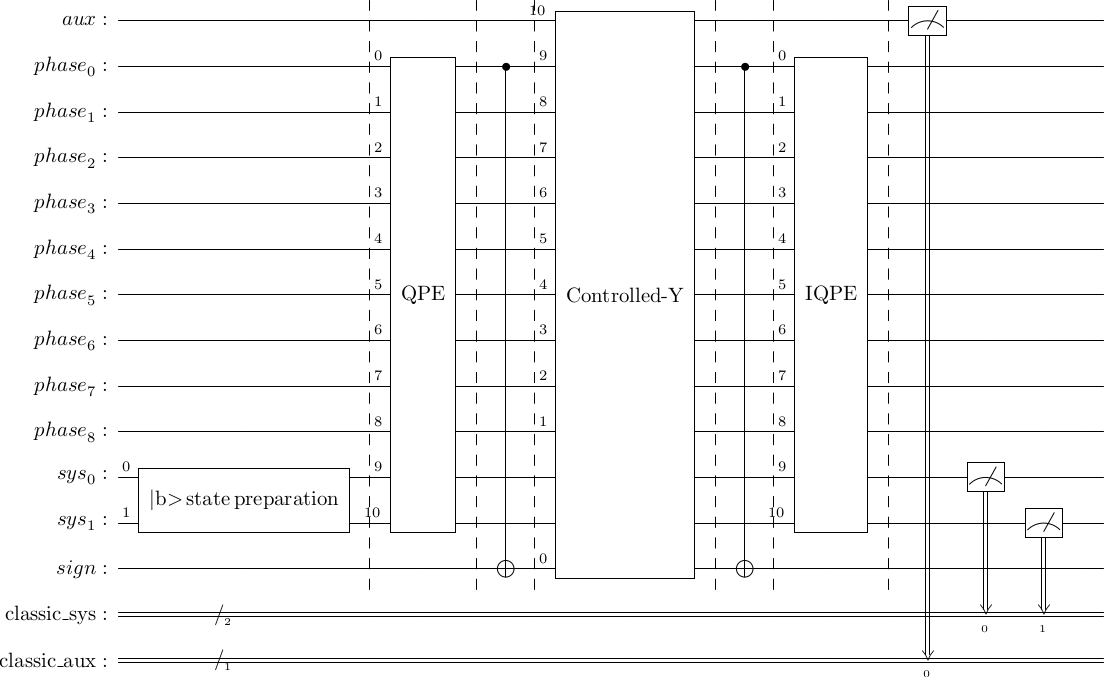

In [35]:
circ = alg.make_circuit()
transpiled_circ = alg.transpile(circ, show_progress=False)
circ.draw(output="latex", filename="HHL.pdf")

In [12]:
# classic
try:
    x_classic = np.linalg.solve(alg.A, alg.b)
except np.linalg.LinAlgError as e:
    print(f"Failed to solve classically, {e.args}")
    x_classic = np.linalg.lstsq(alg.A, alg.b)[0] # first: singular value of A
except Exception as e:
    raise ValueError(f"Failed to solve: {e.args}")
print(x_classic)

for shots in [10**x for x in range(3, 7)]:
    print(f"shots: {shots}")
    result = alg.run(transpiled_circ, shots=shots)

    p, x = alg.analyze(result, show_counts=False)
    print(f"success rate: {p}\n{x}")
    fidelity, deg = hhl_fidelity(x_classic, x)
    print(f"Fidelity: {fidelity}, angle: {deg}")
    print("Classical Norm: {0}, HHL-based norm: {1}".format(np.linalg.norm(x_classic), math.sqrt(p) / alg.C) * 2)



print(x_classic ** 2 / np.linalg.norm(x_classic) ** 2)

[ 0.57043972 -0.21330336 -0.15850984  0.02641831]
shots: 1000
success rate: 0.065
[0.86153846 0.09230769 0.04615385 0.        ]
Fidelity: 0.9975819992039535, angle: 3.9852300756080927
Classical Norm: 0.6298595830750704, HHL-based norm: 0.3211911151663437Classical Norm: 0.6298595830750704, HHL-based norm: 0.3211911151663437
shots: 10000
success rate: 0.0584
[0.79623288 0.14212329 0.05821918 0.00342466]
Fidelity: 0.9989847990384025, angle: 2.5819652246818077
Classical Norm: 0.6298595830750704, HHL-based norm: 0.3044481003078569Classical Norm: 0.6298595830750704, HHL-based norm: 0.3044481003078569
shots: 100000
success rate: 0.06119
[0.80960941 0.12387645 0.06471646 0.00179768]
Fidelity: 0.9998903156200936, angle: 0.8486214249429267
Classical Norm: 0.6298595830750704, HHL-based norm: 0.31163560548370023Classical Norm: 0.6298595830750704, HHL-based norm: 0.31163560548370023
shots: 1000000
success rate: 0.062945
[0.81885773 0.11473509 0.06421479 0.00219239]
Fidelity: 0.9999862800668434, ang

Simulation failed and returned the following error message:
ERROR:  [Experiment 0] save_statevector was not applied to all qubits. Only the full statevector can be saved.
Simulation failed and returned the following error message:
ERROR:  [Experiment 0] save_statevector was not applied to all qubits. Only the full statevector can be saved.
Simulation failed and returned the following error message:
ERROR:  [Experiment 0] save_statevector was not applied to all qubits. Only the full statevector can be saved.


## 4. Apply HHL to NLOS

### 4.1 Solve using HHL

In [13]:
# linear_solver = HHL(testcase.A, testcase.b, lambda_min_eff=0.001, force_cutoff=True)
# circ = linear_solver.make_circuit()
# circ_trans = linear_solver.transpile(circ)

In [14]:
# n = testcase.sample_point_cnt
# result = linear_solver.run(circ_trans, 10**6)
# p, x = linear_solver.analyze(result)

# # return to the original state
# x = np.sqrt(x) * linear_solver.norm(p)
# print(linear_solver.norm(p))

# z = x[(n - 1) * 3:-(linear_solver.A.shape[0] - 3 * (n - 1) - (n + 1))]
# print(p, x, z, sep = '\n')
# print('\n')
# print(np.sqrt(np.average((classic_sol - z) / classic_sol) ** 2))
# print(np.acos(classic_sol @ z / np.linalg.norm(classic_sol) / np.linalg.norm(z)) * 360 / 2 / np.pi)
# print('\n')
# print(np.average(classic_sol / z))

### 4.2 Newly defined class 

In [42]:
from qiskit_aer.library import SaveState
from collections import defaultdict

In [43]:
class HHLwithSWAP(HHL):
    def _get_statevector_hhl(self):
        # registers
        b_reg, c_reg, aux_reg, sign_reg, classic_aux_reg, result_reg = self._create_register()

        circ = QuantumCircuit(aux_reg, b_reg, c_reg, sign_reg)
        self._prepare_state(circ, b_reg)
        self._qpe(circ, b_reg, c_reg, inverse=False)
        circ.barrier()
        # check if phase is negative
        self._assign_neg_sign(circ, c_reg, sign_reg)
        circ.barrier()
        self._controlled_rotation(circ, c_reg, aux_reg, sign_reg)
        circ.barrier()
        self._assign_neg_sign(circ, c_reg, sign_reg)
        circ.barrier()
        self._qpe(circ, b_reg, c_reg, inverse=True)
        circ.barrier()
        print(circ.num_qubits)
        circ.append(SaveState(circ.num_qubits, label="after_hhl"), [*aux_reg, *b_reg, *c_reg, *sign_reg])
        

        transpiled_hhl = self.transpile(circ)
        sim = AerSimulator(method="statevector")
        result: Result = sim.run(transpiled_hhl, shots=1).result()
        full_statevector = Statevector(result.data(0)["after_hhl"])

        vec = full_statevector.to_dict()
        tot_n = circ.num_qubits

        anc_idx = tot_n - 1 - circ.find_bit(aux_reg[0]).index
        b_indices = [tot_n - 1 - circ.find_bit(q).index for q in b_reg]
        c_indices = [tot_n - 1 - circ.find_bit(q).index for q in c_reg]
        sign_idx = tot_n - 1 - circ.find_bit(sign_reg[0]).index

        branch_amps: dict[tuple[str, str], np.ndarray] = defaultdict(
            lambda: np.zeros(1 << self.n_b, dtype=complex)
        )

        p_succ = 0
        for bitstring, amp in vec.items():
            if bitstring[anc_idx] != '1':
                continue
            
            p_succ += abs(amp) ** 2

            c_bits = ''.join(bitstring[p] for p in sorted(c_indices))
            s_bit = bitstring[sign_idx]
            branch_key = (c_bits, s_bit)

            # Build integer index for b-register
            b_bits = ''.join(bitstring[p] for p in sorted(b_indices))
            b_idx = int(b_bits, 2)

            branch_amps[branch_key][b_idx] += amp
        
        self.success_rate = p_succ
        branch_probs = {
            key: np.sum(np.abs(vec) ** 2) for key, vec in branch_amps.items()
        }
        best_key = max(branch_probs, key=branch_probs.get)

        hhl_state = branch_amps[best_key]

        # normalize defensively
        hhl_state /= np.linalg.norm(hhl_state)
        return hhl_state

    def __init__(self, testcase: NLOStestcase, mode: str, lambda_min_eff=1e-02, hhl_state: None | np.ndarray = None, force_cutoff: bool | None = None):
        super().__init__(testcase.A, testcase.b, lambda_min_eff=lambda_min_eff, force_cutoff=force_cutoff)
        if mode not in ['x', 'y', 'z']:
            raise ValueError("Wrong mode: 'x', 'y', 'z' allowed")
        self.mode = mode
        

        # new registers
        anc_reg = QuantumRegister(1, "anc")
        data_reg = QuantumRegister(self.n_b, "data")
        classic_reg = ClassicalRegister(1, "c")
        had_circ = QuantumCircuit(anc_reg, data_reg, classic_reg)

        if mode == 'x':
            state, offset = self._construct_x(testcase)
        elif mode == 'y':
            state, offset = self._construct_y(testcase)
        else:
            state, offset = self._construct_z(testcase)

        self.offset = offset
        self.N = testcase.sample_point_cnt

        # prep
        if hhl_state is None:
            hhl_state = self._get_statevector_hhl()
        self.hhl_state = hhl_state
        print(hhl_state)

        prep_hhl = StatePreparation(Statevector(hhl_state))
        prep_v = StatePreparation(Statevector(state))
        
        had_gate = self._hadamard_test(prep_v, prep_hhl)
        had_circ.append(had_gate, [*anc_reg, *data_reg])

        had_circ.measure(anc_reg, classic_reg)

        self.had_circ = had_circ

    def _hadamard_test(self, prep_v, prep_hhl):
        anc_reg = QuantumRegister(1, "anc")
        data_reg = QuantumRegister(self.n_b, "data")
        circ = QuantumCircuit(anc_reg, data_reg)
        
        circ.h(anc_reg[0])
        circ.append(prep_v.control(1), [*anc_reg, *data_reg])
        circ.append(prep_hhl.inverse().control(1), [*anc_reg, *data_reg])
        circ.h(anc_reg[0])

        had_gate = circ.to_gate()
        had_gate.label = "hadamard"
        return had_gate
    
    def _construct_x(self, testcase: NLOStestcase):
        # self sphereical points:
        # d, v, theta, var_theta, phi, psi, rho * c
        # 0, 1, 2,     3,         4,   5,   6

        ret = np.zeros(((1 << self.n_b),))
        base = (testcase.sample_point_cnt - 1) * 3

        d1_acc = 0
        offset = 0
        for i, x in enumerate(testcase.sample_spherical_points):
            ret[base + i] = np.sin(x[3]) * np.cos(x[2]) + np.sin(x[5]) * np.cos(x[4] + testcase.omega)
            d1_acc += -np.sin(x[5]) * np.cos(x[4] + testcase.omega)
            offset += -x[6] * np.sin(x[5]) * np.cos(x[4] + testcase.omega)
        ret[base + testcase.sample_point_cnt] = d1_acc

        self.ret_norm = np.linalg.norm(ret)

        ret = ret / np.linalg.norm(ret)

        return ret, offset

    
    def _construct_y(self, testcase: NLOStestcase):
        ret = np.zeros(((1 << self.n_b),))
        base = (testcase.sample_point_cnt - 1) * 3

        d1_acc = 0
        offset = 0
        for i, x in enumerate(testcase.sample_spherical_points):
            ret[base + i] = np.sin(x[3]) * np.sin(x[2]) + np.sin(x[5]) * np.sin(x[4] + testcase.omega)
            d1_acc += -np.sin(x[5]) * np.sin(x[4] + testcase.omega)
            offset += -x[6] * np.sin(x[5]) * np.sin(x[4] + testcase.omega)
        ret[base + testcase.sample_point_cnt] = d1_acc

        self.ret_norm = np.linalg.norm(ret)

        ret = ret / np.linalg.norm(ret)

        return ret, offset
    
    def _construct_z(self, testcase: NLOStestcase):
        ret = np.zeros(((1 << self.n_b),))
        base = (testcase.sample_point_cnt - 1) * 3

        d1_acc = 0
        offset = 0
        for i, x in enumerate(testcase.sample_spherical_points):
            ret[base + i] = np.cos(x[3]) + np.cos(x[5])
            d1_acc += -np.cos(x[5]) 
            offset += -x[6] * np.cos(x[5]) 
        ret[base + testcase.sample_point_cnt] = d1_acc

        self.ret_norm = np.linalg.norm(ret)

        ret = ret / np.linalg.norm(ret)

        return ret, offset
    
    def analyze(self, result: Result, show_counts=False) -> tuple[float, np.ndarray]:
        count = result.get_counts()

        if (isinstance(count, dict)):
            if show_counts:
                print(result)
            p0 = count["0"]
            p1 = count["1"]
            had_result = (p0 - p1) / (p0 + p1)
            print("Hadamard test result - 0: {}, 1: {}".format(p0, p1))
            hhl_coor = (self.norm(self.success_rate) * had_result * self.ret_norm + self.offset) / self.N
            print(f"type: {self.mode}, hhl_coor: {hhl_coor}")
        else:
            print(count)
            raise TypeError("result.get_counts() is not type dict[str, int]")

In [44]:
lambda_min = 1e-02
first_hhl = HHLwithSWAP(testcase, 'x', lambda_min_eff=lambda_min, force_cutoff=True)
second_hhl = HHLwithSWAP(testcase, 'y', lambda_min_eff=lambda_min, force_cutoff=True, hhl_state=first_hhl.hhl_state)
third_hhl = HHLwithSWAP(testcase, 'z', lambda_min_eff=lambda_min, force_cutoff=True, hhl_state=first_hhl.hhl_state),
hhl_had = [
    first_hhl,
    second_hhl,
    third_hhl
]

A is not a square matrix
A is evaluated as [[0, A], [AT, 0]]
-----------------------------------
A is not power of 2, pad to make A 16 * 16
-----------------------------------
b is not normalized, normalized to b = [ 7.69767827e-04 -1.50543373e-01 -8.14233179e-01 -6.50581124e-02
  1.74375365e-02 -5.38485564e-01  9.79925514e-02  6.17599978e-02
  8.02512586e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00] during init
-----------------------------------
chosen mode: True
Cutoff enabled: lambda_min_eff - 0.01, min(eigvals) - 0.0
-----------------------------------
17
[ 1.68103219e-03+7.30055754e-08j  4.01767249e-03-7.94112827e-07j
  1.20563483e-02-4.18152000e-07j  2.72586098e-03-7.39511266e-07j
  3.93396975e-03-1.08024968e-06j  7.71472774e-03+7.81640659e-07j
 -1.11476581e-03-1.67866156e-07j  5.01488571e-04-1.30653323e-06j
 -1.67224694e-02+1.19703930e-06j  3.91377462e-01+1.54934751e-06j
  3.13268665e-01-8.73187353e-07j  3.

In [180]:
transpiled_circ = [x.transpile(x.had_circ) for x in hhl_had]

In [183]:
shots=1e6
results = [x.run(transpiled_circ[i], shots=shots) for i, x in enumerate(hhl_had)]

In [184]:
for i in range(3):
    hhl_had[i].analyze(results[i])
print(f"HV: {testcase.HV}")

Hadamard test result - 0: 528382, 1: 471618
norm of b: 1.0
type: x, hhl_coor: 0.47143642864930646
Hadamard test result - 0: 136338, 1: 863662
norm of b: 1.0
type: y, hhl_coor: -12.587674127530004
Hadamard test result - 0: 294602, 1: 705398
norm of b: 1.0
type: z, hhl_coor: -7.310473467001603
HV: [  0.48673081 -12.35875661  -7.18300881]
